In [2]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [3]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [4]:
# To make plots like drawing 
plt.xkcd()

In [5]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

# Análise de Sobrevivência

Análise de sobrevivência, também denominada análise de sobrevida[1], é um ramo da estatística que estuda o tempo de duração esperado até a ocorrência de um ou mais eventos, tais como morte em organismos biológicos e falha em sistemas mecânicos.

A análise de sobrevivência procura responder perguntas como: 

- Qual é a proporção de uma população que sobreviverá depois de um certo tempo? 

- Daqueles que sobrevivem, a que ritmo eles vão morrer ou falhar? 

- Podem várias causas de morte ou falha ser levado em conta? 

- Como circunstâncias ou características específicas aumentam ou diminuem a probabilidade de sobrevivência?

#### Definições de termos comuns na análise de sobrevivência
Os seguintes termos são comumente usados em análises de sobrevivência:

- EVENTO - Morte, ocorrência de doença, recorrência da doença, recuperação ou outra experiência de interesse


- TEMPO - O tempo desde o início de um período de observação (como cirurgia ou início de tratamento) até (i) ocorrer um evento, ou (ii) finalizar o estudo, ou (iii) ocorrer a perda de contato ou retirada do estudo.


- CENSURA - Se um sujeito não experimenta um evento durante o tempo de observação ele será descrito como censurado. O sujeito é censurado no sentido em que nada é observado ou conhecido sobre ele após o tempo de censura. Um sujeito censurado pode ou não ter um evento após o final tempo de observação.


- FUNÇÃO DE SOBREVIVÊNCIA - É uma função, S, que associa a cada tempo t o número S (t) que é a probabilidade de que um sujeito sobreviva além do tempo t.

Ref: [Um modelo de sobrevivência em Stan - Eren M. Elçi](https://ermeel86.github.io/case_studies/surv_stan_example.html)

In [10]:
df = pd.read_csv('./data/mastectomy.csv', sep=",")
df.head(10)

,time,event,metastized
0,23,True,0
1,47,True,0
2,69,True,0
3,70,False,0
4,100,False,0
5,101,False,0
6,148,True,0
7,181,True,0
8,198,False,0
9,208,False,0


Mais precisamente, cada linha no conjunto de dados representa observações de uma mulher com diagnóstico de câncer de mama que foi submetida a mastectomia.

Legenda:

- A coluna `time` representa o tempo (em meses) pós-operatório em que a mulher foi observada.


- A coluna `event` indica se a mulher morreu ou não durante o período de observação.


- A coluna `metastized` representa se o câncer tinha metástase antes da cirurgia.

### Descritiva

In [47]:
df.groupby(by=['metastized', 'event']).describe()

time                                                    \
                 count        mean        std   min    25%    50%    75%   
metastized event                                                           
0          False   7.0  159.000000  65.475186  70.0  100.5  198.0  210.0   
           True    5.0   93.600000  67.748063  23.0   47.0   69.0  148.0   
1          False  11.0  151.090909  52.673436  76.0  108.0  145.0  200.0   
           True   21.0   48.000000  37.753146   5.0   24.0   40.0   61.0   

                         
                    max  
metastized event         
0          False  224.0  
           True   181.0  
1          False  225.0  
           True   143.0

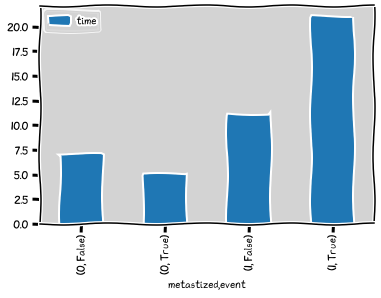

In [48]:
df.groupby(by=['metastized', 'event']).count().plot.bar()
plt.show()

### Modelo

Função de sobrevivência $S(t)$:

$$ S(t) = \mathbb{P} (T > t) = e^{-H(t)} $$


$T :=$ é o tempo de sobrevivência de um indivíduo.

$(T > t):=$ Tempo ($T$) que o paciente sobreviveu além do tempo $t$.

$H(t):=$ definido como perigo acumulado.



In [76]:
model = """
    data {
        int<lower=1> N_uncensored;  // Number of individuals not censured - event == 1
        int<lower=1> N_censored;  // Number of individuals censured - event == 0
        int<lower=0> NC;  // Number of covariates
        
        matrix[N_censored, NC] X_censored;
        matrix[N_uncensored, NC] X_uncensored;
        
        vector<lower=0>[N_censored] times_censored;                          
        vector<lower=0>[N_uncensored] times_uncensored;     
    }
    
    parameters {
        vector[NC] betas;
        real intercept;
    }
    
    model {
        // Prioris
        betas ~ normal(0,2);                                                            
        intercept ~ normal(-5,2);                                                     
        
        // Likelihood
        target += exponential_lpdf(times_uncensored | exp(intercept + X_uncensored * betas)); 
        target += exponential_lccdf(times_censored | exp(intercept + X_censored * betas));  
    }
    
    generated quantities {
        vector[N_uncensored] times_uncensored_sampled;
        
        for(i in 1:N_uncensored) {
            times_uncensored_sampled[i] = exponential_rng(exp(intercept+X_uncensored[i,]*betas));
        }
    }

"""

In [80]:
# Build the data dict to stan
covariates_name = ['metastized']  # From the inputs user


dat_list = {
    'N_uncensored': len(df[df['event'] == 1]),
    'N_censored': len(df[df['event'] == 0]),
    'NC': len(covariates_name),
    'X_censored': np.matrix(df.loc[df['event'] == 0, covariates_name]),
    'X_uncensored': np.matrix(df.loc[df['event'] == 1, covariates_name]),
    'times_censored': df.loc[df['event'] == 0, 'time'].values,
    'times_uncensored': df.loc[df['event'] == 1, 'time'].values
}

In [81]:
posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_72fjebnh/model_hzb4nq3j.stan', line 25, column 8 to column 93)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be reject

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_72fjebnh/model_hzb4nq3j.stan', line 25, column 8 to column 93)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: exponential_lpdf: Inverse scale parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_72fjebnh/model_hzb4nq3j.stan', line 25, column 8 to column 93)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then you

In [82]:
survival = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(dat_list.keys())
)

In [83]:
az.summary(survival)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.905,0.472,0.059,1.838,0.015,0.011,940.0,899.0,1.0
intercept,-5.785,0.426,-6.574,-5.031,0.014,0.010,973.0,1209.0,1.0
times_uncensored_sampled[0],353.805,429.394,0.075,1078.370,7.933,5.610,3176.0,3150.0,1.0
times_uncensored_sampled[1],354.990,409.473,0.473,1056.280,7.904,5.589,2950.0,2992.0,1.0
times_uncensored_sampled[2],344.882,428.933,0.112,1025.539,8.269,5.847,2962.0,3396.0,1.0
times_uncensored_sampled[3],360.318,450.406,0.144,1087.427,8.473,5.992,2619.0,3434.0,1.0
times_uncensored_sampled[4],362.178,411.853,0.035,1061.510,7.877,5.570,2891.0,3322.0,1.0
times_uncensored_sampled[5],135.071,137.268,0.074,376.718,2.216,1.567,3774.0,3607.0,1.0
times_uncensored_sampled[6],134.786,137.092,0.069,389.821,2.198,1.562,3745.0,3766.0,1.0
times_uncensored_sampled[7],134.730,137.489,0.160,377.542,2.275,1.609,3665.0,3390.0,1.0


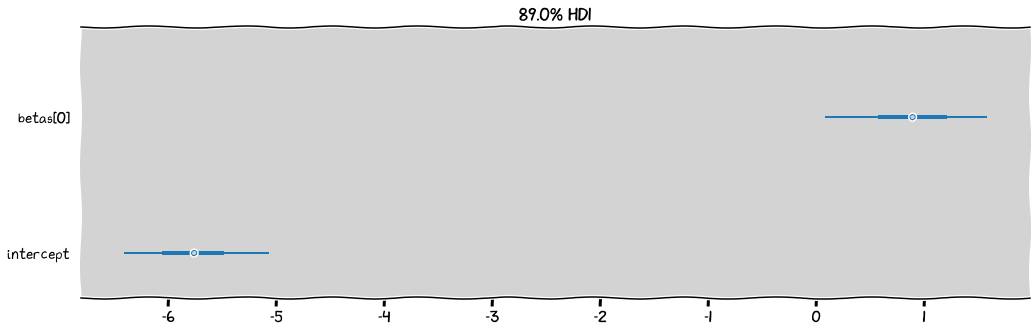

In [87]:
az.plot_forest(survival, var_names=['betas', 'intercept'], combined=True, figsize=(17, 5), hdi_prob=0.89)
plt.show()